In [1]:
import os

import torch
from accelerate import Accelerator
from diffusers import StableDiffusionPipeline
from riffusion.datatypes import InferenceInput, PromptInput
from riffusion.riffusion_pipeline import RiffusionPipeline
from PIL import Image
from riffusion.spectrogram_params import SpectrogramParams

from utils.Reconstruct_Audio import *

In [28]:
prompt = "Hard Rock"  # Example prompt
model_id = "runwayml/stable-diffusion-v1-5"
num_images=1
guidance_scale=7.5
accelerator = Accelerator()
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(accelerator.device)

# Load fine-tuned unet
pipeline.load_lora_weights("dis-2k")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [29]:
pipeline = RiffusionPipeline(pipeline.vae, 
                             pipeline.text_encoder,
                             pipeline.tokenizer,
                             pipeline.unet,
                             pipeline.scheduler,
                             pipeline.safety_checker,
                             pipeline.feature_extractor)

In [35]:
import json
# Example usage
input_json = '''
{
  "alpha": 0.75,
  "num_inference_steps": 50,
  "seed_image_id": "og_beat",
  "start": {
    "prompt": "church bells on sunday",
    "seed": 42,
    "denoising": 0.75,
    "guidance": 7.0
  },
  "end": {
    "prompt": "jazz with piano",
    "seed": 123,
    "denoising": 0.75,
    "guidance": 7.0
  }
}
'''
input_dict = json.loads(input_json)
alpha = float(input_dict["alpha"])
num_inference_steps = int(input_dict["num_inference_steps"])
seed_image_id = input_dict["seed_image_id"]

assert input_dict["start"] is not None

start_prompt = PromptInput(**input_dict["start"])

if input_dict["end"] is None:
    end_prompt = start_prompt
else:
    end_prompt = PromptInput(**input_dict["end"])

input_data = InferenceInput(start=start_prompt, 
                            end=start_prompt,
                            alpha=alpha,
                            num_inference_steps=num_inference_steps,
                            seed_image_id=seed_image_id)

print(input_data)

InferenceInput(start=PromptInput(prompt='church bells on sunday', seed=42, negative_prompt=None, denoising=0.75, guidance=7.0), end=PromptInput(prompt='church bells on sunday', seed=42, negative_prompt=None, denoising=0.75, guidance=7.0), alpha=0.75, num_inference_steps=50, seed_image_id='og_beat', mask_image_id=None)


In [37]:
seed_image = "seed_images/og_beat.png"
init_image = Image.open(seed_image).convert("RGB")
spectrogram = pipeline.riffuse(inputs=input_data, init_image=init_image)

C:\Users\Sai\Documents\Neu\text-to-music-generation\venv\Lib\site-packages\diffusers\models\attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)


  0%|          | 0/38 [00:00<?, ?it/s]

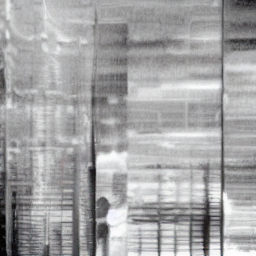

In [40]:
spectrogram

In [8]:
result_dir = "Results/Spectrogram"
file_name = "og_beat_hard_rock.png"
spectrogram_path = os.path.join(result_dir, file_name)
# spectrogram.save(spectrogram_path)

In [9]:
audio_target_dir = "Results/Reconstructed_Audio"
audio_file_name = "og_beat_hard_rock.wav"
target_path = os.path.join(audio_target_dir, audio_file_name)
# reconstruct_single_audio_from_spectrogram(target_path, spectrogram_path=spectrogram_path)
reconstruct_single_audio_from_spectrogram(target_path, spectrogram_img=spectrogram)

In [1]:
from riffusion.spectrogram_image_converter import SpectrogramImageConverter
from riffusion.spectrogram_params import SpectrogramParams
from PIL import Image

path = "seed_images/og_beat512.png"
seed = Image.open(path).convert("RGB")
params = SpectrogramParams()
converter = SpectrogramImageConverter(params=params, device='cuda')
clip = converter.audio_from_spectrogram_image(seed)

out_wav_path = "Results/og_beat_rif.wav"
clip.export(out_wav_path, format="wav")

C:\Users\Sai\Documents\Neu\text-to-music-generation\venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
C:\Users\Sai\Documents\Neu\text-to-music-generation\venv\Lib\site-packages\riffusion\spectrogram_image_converter.py:21: UserWarning: WARNING: cuda is not available, using cpu instead.
  self.converter = SpectrogramConverter(params=params, device=device)


<_io.BufferedRandom name='Results/og_beat_rif.wav'>

In [2]:
clip